In [18]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel('ads_dim_cleaned.xlsx')
columns_to_regress= ['ad_id', 'log_ad_revenue', 'log_avg_ad_revenue', 'log_baseline_st', 'days_since_punish', 'punish_category_High','punish_category_Low','punish_category_Medium']
# Drop the columns in columns_to_regress to get the rest
other_columns_df = df.drop(columns_to_regress, axis=1)
df = df[columns_to_regress]
df.to_excel('Ads_TrainingData.xlsx', index = None)

other_columns_df.head()

,delivery_country,avg_ad_revenue,baseline_st,product_line,task_type_en,ad_rev_per_day
0,US,550.298948,1.000000,Auction Ads,auction_relation,1.365904
1,SA,122.077026,0.911290,RIE,Ad Group Recall (Merged),0.908736
2,AU,0.615683,1.048387,Auction Ads,auction_relation,0.000341
3,NZ,0.615683,0.838710,Auction Ads,auction_relation,1.922536
4,NZ,0.615683,0.838710,Auction Ads,auction_relation,0.000299


In [19]:
# using
# - log_ad_rev
# - log_avg_ad_rev
# - log_baseline_st
# - days_since_punish
# - punish_category_High
# - punish_category_Low
# - punish_category_Medium

trainingData = pd.read_excel('Ads_TrainingData.xlsx')
df_lr = trainingData.copy()
df_gb = trainingData.copy()
df_rf = trainingData.copy()

inf_count_lr = np.isinf(df_lr).sum()
inf_count_gb = np.isinf(df_gb).sum()

# Replace infinities with NaN
df_lr = df_lr.replace([np.inf, -np.inf], np.nan)
df_gb = df_gb.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN values
df_lr = df_lr.dropna()
df_gb = df_gb.dropna()

ad_id_lr = df_lr['ad_id']
df_lr.drop(['ad_id'], axis=1, inplace=True)

ad_id_gb = df_gb['ad_id']
df_gb.drop(['ad_id'], axis=1, inplace=True)

ad_id_rf = df_rf['ad_id']
df_rf.drop(['ad_id'], axis=1, inplace=True)

In [20]:
# use linear regression
coefs = {var: [] for var in df_lr.columns}
intercepts = []

for column in df_lr.columns:
    X = df_lr.drop(column, axis=1)
    y = df_lr[column]
    reg = LinearRegression().fit(X, y)
    print(f"Dependent variable: {column}")
    print("Coefficients:")
    for var, coef in zip(X.columns, reg.coef_):
        print(f"{var}: {coef}")
        coefs[var].append(coef)
    print(f"Intercept: {reg.intercept_}")
    intercepts.append(reg.intercept_)
    print('\n')

# Calculate the average coefficient for each independent variable
avg_coefs = {var: sum(coefs[var])/len(coefs[var]) for var in coefs}
# Calculate the average intercept
avg_intercept = sum(intercepts)/len(intercepts)
print("Average coefficients:")
for var, avg_coef in avg_coefs.items():
    print(f"{var}: {avg_coef}")
print(f"Average intercept: {avg_intercept}")

# Average coefficients for Linear Regression:
# log_ad_revenue: 0.05028734245059719
# log_avg_ad_revenue: 0.1720630121016464
# log_baseline_st: 0.03414099093159397
# days_since_punish: -0.000850712369239419
# punish_category_High: -3.6590537671294165
# punish_category_Low: 6.830706334102917
# punish_category_Medium: -4.171652566973497
# Average intercept: 6.908675333663626

Dependent variable: log_ad_revenue
Coefficients:
log_avg_ad_revenue: 0.3656564919137652
log_baseline_st: 0.10542655222779942
days_since_punish: -0.006589803808632298
punish_category_High: -0.8404567515841369
punish_category_Low: 0.5473592833040757
punish_category_Medium: 0.2930974682800599
Intercept: -0.5137980885936173


Dependent variable: log_avg_ad_revenue
Coefficients:
log_ad_revenue: 0.2736751636417377
log_baseline_st: 0.2189876926751676
days_since_punish: 0.010721037040092057
punish_category_High: 0.8117246637495495
punish_category_Low: -0.6203785140924429
punish_category_Medium: -0.19134614965711907
Intercept: -0.49932862477981255


Dependent variable: log_baseline_st
Coefficients:
log_ad_revenue: 0.1470382079827475
log_avg_ad_revenue: 0.40807294928404014
days_since_punish: -0.009235507446896218
punish_category_High: 0.659194084076851
punish_category_Low: -0.6982418685397549
punish_category_Medium: 0.03904778446290365
Intercept: 0.2513618467969152


Dependent variable: days_sin

In [21]:
# Average coefficients and intercept for linear regression
avg_coefs = {
    'log_ad_revenue': 0.05028734245059719,
    'log_avg_ad_revenue': 0.1720630121016464,
    'log_baseline_st': 0.03414099093159397,
    'days_since_punish': -0.000850712369239419,
    'punish_category_High': -3.6590537671294165,
    'punish_category_Low': 6.830706334102917,
    'punish_category_Medium': -4.171652566973497
}
avg_intercept = 6.908675333663626

# Define the independent variables
X = df_lr[list(avg_coefs.keys())]

# Calculate the weighted average of the independent variables
ad_score_pred = X.dot(np.array(list(avg_coefs.values()))) + avg_intercept

# Add the ad_id column and the predicted values for Y back to the DataFrame
df_lr['ad_id'] = ad_id_lr
df_lr['ad_score_pred'] = ad_score_pred
# Concatenate the two dataframes horizontally (axis=1)
combined_df_lr = pd.concat([df_lr, other_columns_df], axis=1)
combined_df_lr.to_excel('ad_df_lr.xlsx',index=None)


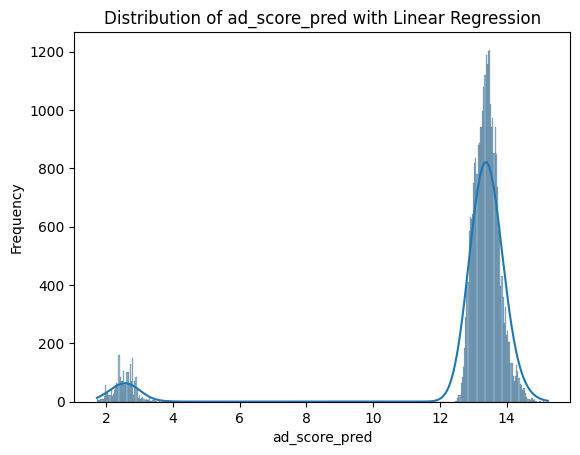

In [22]:
# Plot distribution of mod_score_pred 
sns.histplot(df_lr['ad_score_pred'], kde = True)

plt.title('Distribution of ad_score_pred with Linear Regression')
plt.xlabel('ad_score_pred')
plt.ylabel('Frequency')
plt.show()

In [23]:
# use gradient boosting regression
from sklearn.ensemble import GradientBoostingRegressor
# Initialize a dictionary to store the feature importances for each independent variable
importances = {var: [] for var in df_gb.columns}
# Initialize a list to store the intercepts for each dependent variable
intercepts = []

for column in df_gb.columns:
    X = df_gb.drop(column, axis=1)
    y = df_gb[column]
    reg = GradientBoostingRegressor().fit(X, y)
    print(f"Dependent variable: {column}")
    print("Feature importances:")
    for var, imp in zip(X.columns, reg.feature_importances_):
        print(f"{var}: {imp}")
        importances[var].append(imp)
    intercepts.append(reg.init_.constant_[0][0])
    print('\n')

# Calculate the average feature importance for each independent variable
avg_importances = {var: sum(importances[var])/len(importances[var]) for var in importances}
# Calculate the average intercept
avg_intercept = sum(intercepts)/len(intercepts)

print("Average feature importances:")
for var, avg_imp in avg_importances.items():
    print(f"{var}: {avg_imp}")
print(f"Average intercept: {avg_intercept}")

# GradientBoostingRegressor Average feature importances:
# log_ad_revenue: 0.14195301140743236
# log_avg_ad_revenue: 0.22834342617645617
# log_baseline_st: 0.12878527944219853
# days_since_punish: 0.3350780564283029
# punish_category_High: 0.0006211573549107668
# punish_category_Low: 0.26039532529140114
# punish_category_Medium: 0.07149041056596481
# Average intercept: 11.865962381896543


Dependent variable: log_ad_revenue
Feature importances:
log_avg_ad_revenue: 0.746512706067649
log_baseline_st: 0.2364110727902933
days_since_punish: 0.015891491925805926
punish_category_High: 0.00011922828567792723
punish_category_Low: 0.00017659246724855446
punish_category_Medium: 0.0008889084633253129


Dependent variable: log_avg_ad_revenue
Feature importances:
log_ad_revenue: 0.4833045362390706
log_baseline_st: 0.49463259020919176
days_since_punish: 0.021204752881163004
punish_category_High: 0.0
punish_category_Low: 0.00011020503863538293
punish_category_Medium: 0.0007479156319391847


Dependent variable: log_baseline_st
Feature importances:
log_ad_revenue: 0.359020504054739
log_avg_ad_revenue: 0.5601200161671781
days_since_punish: 0.05279866943002957
punish_category_High: 2.260046642577286e-05
punish_category_Low: 0.021597629746862912
punish_category_Medium: 0.006440580134764737


Dependent variable: days_since_punish
Feature importances:
log_ad_revenue: 0.009393028150241926
log_a

In [26]:
# Gradient boosting average feature importances and intercept
avg_importances = {
    'log_ad_revenue': 0.14195301140743236,
    'log_avg_ad_revenue': 0.22834342617645617,
    'log_baseline_st': 0.12878527944219853,
    'days_since_punish': 0.3350780564283029,
    'punish_category_High': 0.0006211573549107668,
    'punish_category_Low': 0.26039532529140114,
    'punish_category_Medium': 0.07149041056596481
}
avg_intercept = 11.865962381896543

# Define the independent variables
X = df_gb[list(avg_importances.keys())]
# Calculate the weighted average of the independent variables
ad_score_pred = X.dot(np.array(list(avg_importances.values()))) + avg_intercept

# Add the ad_id column and the predicted values for Y back to the DataFrame
df_gb['ad_id'] = ad_id_gb
df_gb['ad_score_pred'] = ad_score_pred
# Concatenate the two dataframes horizontally (axis=1)
combined_df_gb = pd.concat([df_gb, other_columns_df], axis=1)
combined_df_gb.to_excel('ad_df_gb.xlsx',index=None)

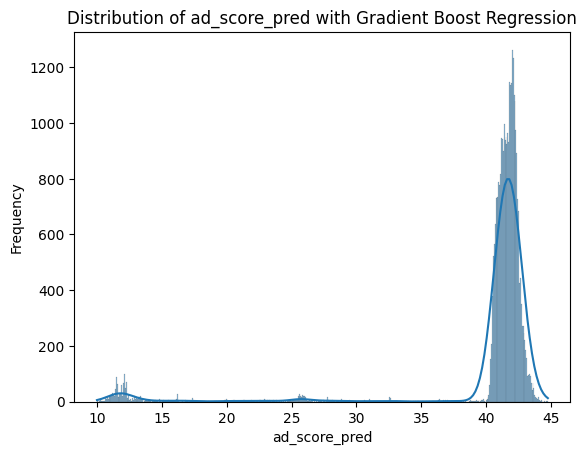

In [27]:
# Plot distribution of mod_score_pred 
sns.histplot(df_gb['ad_score_pred'], kde = True)

plt.title('Distribution of ad_score_pred with Gradient Boost Regression')
plt.xlabel('ad_score_pred')
plt.ylabel('Frequency')
plt.show()

In [28]:
# use random forest regressor
from sklearn.ensemble import RandomForestRegressor

importances_rf = {var: [] for var in df_rf.columns}
intercepts_rf = []

for column in df_rf.columns:
    X = df_rf.drop(column, axis=1)
    y = df_rf[column]
    reg = RandomForestRegressor().fit(X, y)
    print(f"Dependent variable: {column}")
    print("Feature importances:")
    for var, imp in zip(X.columns, reg.feature_importances_):
        print(f"{var}: {imp}")
        importances_rf[var].append(imp)
    intercepts_rf.append(reg.predict([[0]*len(X.columns)])[0] - sum(reg.feature_importances_))
    print('\n')

avg_importances_rf = {var: sum(importances_rf[var])/len(importances_rf[var]) for var in importances_rf}
avg_intercept_rf = sum(intercepts_rf)/len(intercepts_rf)

print("Average feature importances for Random Forest:")
for var, avg_imp in avg_importances_rf.items():
    print(f"{var}: {avg_imp}")
print(f"Average intercept: {avg_intercept_rf}")


# Average feature importances for Random Forest:
# log_ad_revenue: 0.19499777336206325
# log_avg_ad_revenue: 0.24575691297391974
# log_baseline_st: 0.08732634386027366
# days_since_punish: 0.34688606399499267
# punish_category_High: 0.0006119137951100534
# punish_category_Low: 0.2265959863533221
# punish_category_Medium: 0.06449167232698529
# Average intercept: 5.739648390482786

Dependent variable: log_ad_revenue
Feature importances:
log_avg_ad_revenue: 0.8034177818070105
log_baseline_st: 0.16916108089802914
days_since_punish: 0.019173430999235085
punish_category_High: 5.659487065726782e-05
punish_category_Low: 0.0035591782958034864
punish_category_Medium: 0.004631933129264524




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Dependent variable: log_avg_ad_revenue
Feature importances:
log_ad_revenue: 0.6829360648253079
log_baseline_st: 0.28535369072604433
days_since_punish: 0.026278902742423945
punish_category_High: 1.6077394897936242e-05
punish_category_Low: 0.002337880718797579
punish_category_Medium: 0.0030773835925283232




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Dependent variable: log_baseline_st
Feature importances:
log_ad_revenue: 0.4218813828501387
log_avg_ad_revenue: 0.5501468249275321
days_since_punish: 0.01916657628238117
punish_category_High: 1.2603239346589699e-05
punish_category_Low: 0.004035362906910528
punish_category_Medium: 0.004757249793690989




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Dependent variable: days_since_punish
Feature importances:
log_ad_revenue: 0.03777976216868699
log_avg_ad_revenue: 0.07466878256036463
log_baseline_st: 0.045850851951013544
punish_category_High: 4.54199567169288e-05
punish_category_Low: 0.8416133319610805
punish_category_Medium: 4.1851402137450567e-05




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Dependent variable: punish_category_High
Feature importances:
log_ad_revenue: 0.02738943032824571
log_avg_ad_revenue: 0.04630808854861119
log_baseline_st: 0.023592439586554916
days_since_punish: 0.5282684254922978
punish_category_Low: 0.0
punish_category_Medium: 0.3744416160442904




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Dependent variable: punish_category_Low
Feature importances:
log_ad_revenue: 0.0
log_avg_ad_revenue: 0.0
log_baseline_st: 0.0
days_since_punish: 1.0
punish_category_High: 0.0
punish_category_Medium: 0.0




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Dependent variable: punish_category_Medium
Feature importances:
log_ad_revenue: 0.0
log_avg_ad_revenue: 0.0
log_baseline_st: 0.0
days_since_punish: 0.48842904845361806
punish_category_High: 0.003540787309041598
punish_category_Low: 0.5080301642373404


Average feature importances for Random Forest:
log_ad_revenue: 0.19499777336206325
log_avg_ad_revenue: 0.24575691297391974
log_baseline_st: 0.08732634386027366
days_since_punish: 0.34688606399499267
punish_category_High: 0.0006119137951100534
punish_category_Low: 0.2265959863533221
punish_category_Medium: 0.06449167232698529
Average intercept: 5.739648390482786


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [29]:
avg_importances = {
    'log_ad_revenue': 0.14195301140743236,
    'log_avg_ad_revenue': 0.24575691297391974,
    'log_baseline_st': 0.08732634386027366,
    'days_since_punish': 0.34688606399499267,
    'punish_category_High': 0.0006119137951100534,
    'punish_category_Low': 0.2265959863533221,
    'punish_category_Medium': 0.06449167232698529
}
avg_intercept = 5.739648390482786

# Define the independent variables
X = df_rf[list(avg_importances.keys())]
# Calculate the weighted average of the independent variables
ad_score_pred = X.dot(np.array(list(avg_importances.values()))) + avg_intercept

# Add the ad_id column and the predicted values for Y back to the DataFrame
df_rf['ad_id'] = ad_id_gb
df_rf['ad_score_pred'] = ad_score_pred
# Concatenate the two dataframes horizontally (axis=1)
combined_df_rf = pd.concat([df_rf, other_columns_df], axis=1)
combined_df_rf.to_excel('ad_df_rf.xlsx',index=None)

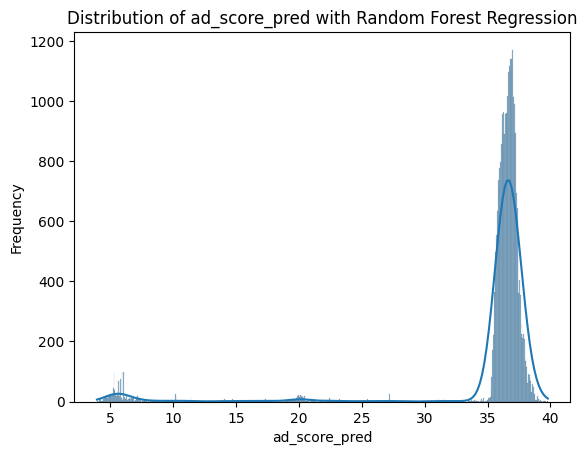

In [30]:
# Plot distribution of mod_score_pred 
sns.histplot(df_rf['ad_score_pred'], kde = True)

plt.title('Distribution of ad_score_pred with Random Forest Regression')
plt.xlabel('ad_score_pred')
plt.ylabel('Frequency')
plt.show()